<a href="https://colab.research.google.com/github/marianatiele/AprendizadoMaquina_Projetos/blob/main/Testando_Redes_Neurais__Recorrente_LSMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Referência
[Rede neural Recorrente - LSMT](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

O problema que você vai olhar neste post é o problema de previsão de passageiros de companhias aéreas internacionais.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models  import Sequential
# from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [48]:
base = pd.read_csv('airline-passengers.csv')
base.head(2)

,Month,Passengers
0,1949-01,112
1,1949-02,118


In [51]:
# usecols=[1] -> colunas a ser carregada
dados = pd.read_csv('airline-passengers.csv',usecols=[1],engine='python')
dados.head(2)

,Passengers
0,112
1,118


In [13]:
dados.isnull().sum()

Passengers    0
dtype: int64

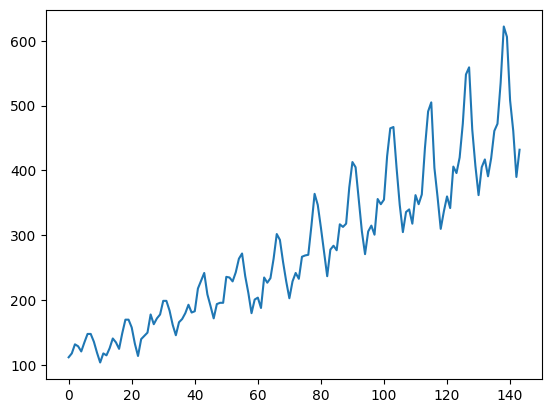

In [15]:
plt.plot(dados)
plt.show()

Você pode escrever uma função simples para converter a única coluna de dados em um conjunto de dados de duas colunas: a primeira coluna contendo a contagem de passageiros (t) deste mês e a segunda coluna contendo a contagem de passageiros do próximo mês (t+1) a ser prevista.

In [17]:
# corrigir a semente de números aleatórios para garantir que seus resultados sejam reproduzíveis.
tf.random.set_seed(7)

In [18]:
#  extrair a matriz NumPy do dataframe e converter os valores inteiros em valores de ponto flutuante,
#  que são mais adequados para modelagem com uma rede neural.
dados = dados.values
dados = dados.astype('float32')

In [20]:
# normalizando os dados, na escala de (0,1)
scaler = MinMaxScaler(feature_range=(0,1))
dados = scaler.fit_transform(dados)

In [24]:
dados[1]

array([0.02702703], dtype=float32)

In [25]:
# calcula o índice do ponto de divisão e separa os dados nos conjuntos de dados de treinamento,
# com 67% das observações usadas para treinar o modelo, deixando os 33% restantes para testar o modelo.
#  podemos usar o train_test_spilt()

train_size = int(len(dados) * 0.67)
test_size = len(dados) - train_size
train, test = dados[0:train_size,:], dados[train_size:len(dados),:]
print(len(train), len(test))

96 48


In [27]:
# Esse padrão criará um conjunto de dados onde X é o número de passageiros em um determinado momento (t),
#  e Y é o número de passageiros no próximo momento (t + 1).
# convert an array of values into a dataset matrix
def create_dataset(dados, look_back=1):
 dataX, dataY = [], []
#  a = 0
 for i in range(len(dados)-look_back-1):
  a = dados[i: (i+look_back), 0]
  dataX.append(a)
  dataY.append(dados[i + look_back, 0])

 return np.array(dataX), np.array(dataY)

In [34]:
# cria os dados para treino e teste
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [36]:
#trainX,
trainY

array([0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984557,
       0.08494207, 0.08494207, 0.06177607, 0.02895753, 0.        ,
       0.02702703, 0.02123553, 0.04247104, 0.07142857, 0.05984557,
       0.04054055, 0.08687258, 0.12741312, 0.12741312, 0.10424709,
       0.05598456, 0.01930502, 0.06949806, 0.07915059, 0.08880308,
       0.14285713, 0.11389962, 0.13127413, 0.14285713, 0.18339768,
       0.18339768, 0.15444016, 0.11196911, 0.08108109, 0.1196911 ,
       0.12934363, 0.14671814, 0.17181468, 0.14864865, 0.15250966,
       0.22007722, 0.24324325, 0.26640925, 0.2027027 , 0.16795367,
       0.13127413, 0.17374519, 0.17760617, 0.17760617, 0.25482625,
       0.25289574, 0.24131274, 0.26833975, 0.3088803 , 0.32432434,
       0.25675675, 0.20656371, 0.14671814, 0.18725869, 0.19305018,
       0.16216215, 0.25289574, 0.23745173, 0.25096524, 0.3088803 ,
       0.38223937, 0.36486486, 0.2992278 , 0.24131274, 0.1911197 ,
       0.24131274, 0.26640925, 0.24903473, 0.31467178, 0.31853

A rede LSTM espera que os dados de entrada (X) sejam fornecidos com uma estrutura de matriz específica na forma de [amostras, etapas de tempo,recursos].

Atualmente, os dados estão na forma de [exemplos, recursos], e você está enquadrando o problema como uma etapa de tempo para cada amostra. Você pode transformar o trem preparado e os dados de entrada de teste na estrutura esperada usando numpy.reshape() da seguinte maneira:

In [37]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

A rede tem uma camada visível com 1 entrada, uma camada oculta com 4 blocos LSTM ou neurônios, e uma camada de saída que faz uma previsão de valor único. A função de ativação sigmoide padrão é usada para os blocos LSTM. A rede é treinada para 100 épocas, e um tamanho de lote de 1 é usado.

In [38]:
# Criando a rede neural LSTM, com 4 camadas e 1 camada densa que é a saída?
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 3s - loss: 0.0398 - 3s/epoch - 27ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0183 - 325ms/epoch - 3ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0147 - 298ms/epoch - 3ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0135 - 303ms/epoch - 3ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0123 - 320ms/epoch - 3ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0109 - 263ms/epoch - 3ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0098 - 188ms/epoch - 2ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0087 - 184ms/epoch - 2ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0078 - 193ms/epoch - 2ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0067 - 208ms/epoch - 2ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0058 - 179ms/epoch - 2ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0050 - 193ms/epoch - 2ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0044 - 179ms/epoch - 2ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0038 - 187ms/epoch - 2ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0033 - 194ms/epoch - 2ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0030 - 193ms/epoc

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101 (404.00 Byte)
Trainable params: 101 (404.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
# Previsões
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 9ms/step
Train Score: 22.90 RMSE
Test Score: 48.35 RMSE


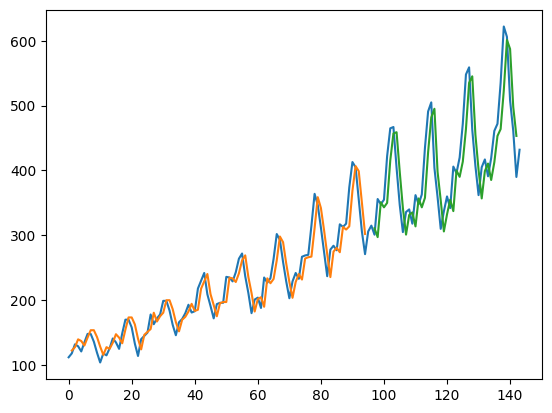

In [44]:
# os dados são plotados, mostrando o conjunto de dados original em azul, as
#  previsões para o conjunto de dados de treinamento em verde
# e as previsões no conjunto de dados de teste não visto em vermelho.
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dados)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dados)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dados)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dados))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()